<a href="https://colab.research.google.com/github/Christian-F-Badillo/Samejima_reparameterize/blob/main/Samejima_parameter_recovery_bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recuperación de Parametros

## Datos

### Librerias

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from google.colab import drive
import os

In [ ]:
!pip install pystan

In [ ]:
import stan
import nest_asyncio
import asyncio

# Paqueterias pa que jale el modelo
nest_asyncio.apply()
asyncio.run(asyncio.sleep(1))

In [ ]:
drive.mount("/content/drive")
os.chdir("/content/drive/MyDrive")
%pwd

### Carga de Datos


In [ ]:
url = 'https://raw.githubusercontent.com/Christian-F-Badillo/Samejima_reparameterize/main/datos.csv'
data = pd.read_csv(url)
data.head()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15
0,1,0,2,3,1,2,1,2,2,3,1,2,1,2,1,0
1,2,3,2,2,1,2,1,2,2,0,3,3,2,0,1,0
2,3,3,1,2,1,2,1,2,0,2,1,1,2,0,1,0
3,4,0,2,2,1,3,1,2,3,0,3,3,2,2,1,3
4,5,3,2,2,2,2,3,2,0,0,3,1,1,1,1,2


### Descripción de datos

In [ ]:
data.describe( )

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,500.500000,1.770000,1.297000,1.82100,1.270000,1.87200,1.347000,1.672000,1.452000,1.779000,1.81300,1.971000,1.789000,1.29100,0.827000,1.073000
std,288.819436,1.324709,0.653619,1.00098,1.056511,0.47733,0.983646,0.697784,1.272523,1.400757,1.28829,1.154769,0.764895,1.28529,0.487143,0.896926
min,1.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,250.750000,0.000000,1.000000,1.00000,0.000000,2.00000,1.000000,2.000000,0.000000,0.000000,1.00000,1.000000,2.000000,0.00000,1.000000,0.000000
50%,500.500000,2.000000,1.000000,2.00000,1.000000,2.00000,1.000000,2.000000,2.000000,3.000000,3.00000,2.000000,2.000000,1.00000,1.000000,1.000000
75%,750.250000,3.000000,2.000000,3.00000,2.000000,2.00000,2.000000,2.000000,3.000000,3.000000,3.00000,3.000000,2.000000,3.00000,1.000000,2.000000
max,1000.000000,3.000000,3.000000,3.00000,3.000000,3.00000,3.000000,3.000000,3.000000,3.000000,3.00000,3.000000,3.000000,3.00000,3.000000,3.000000


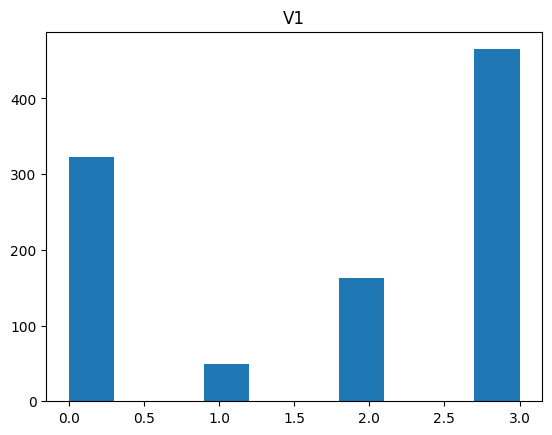

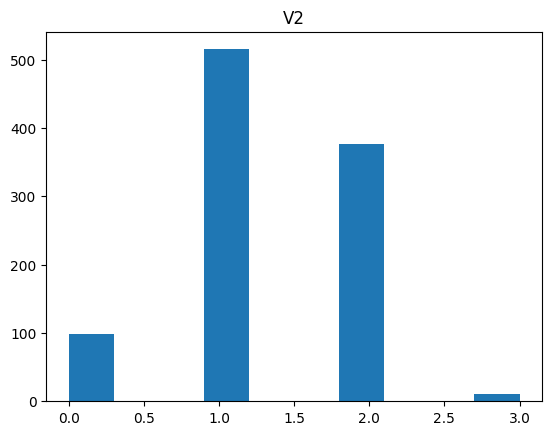

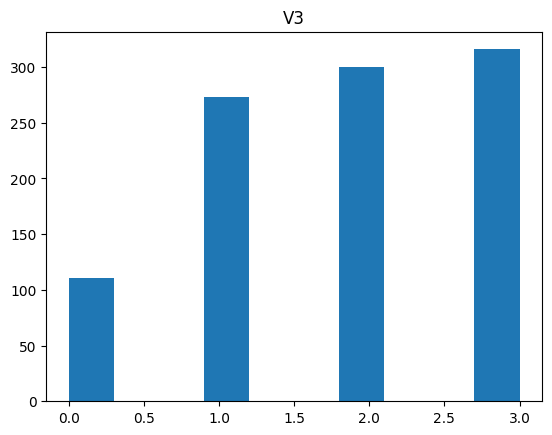

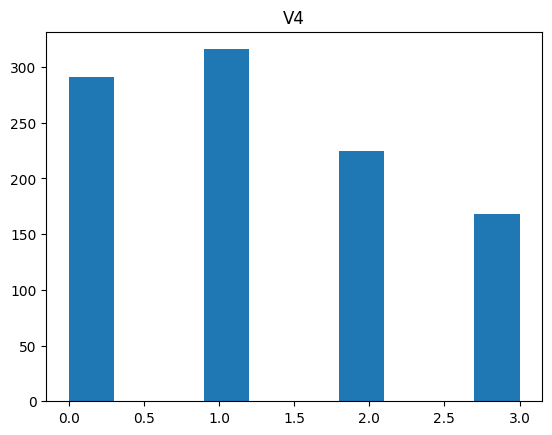

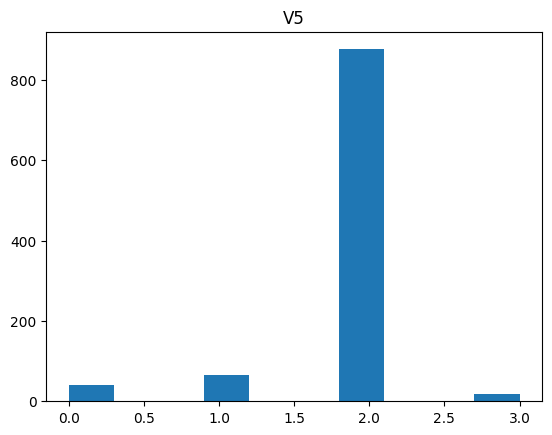

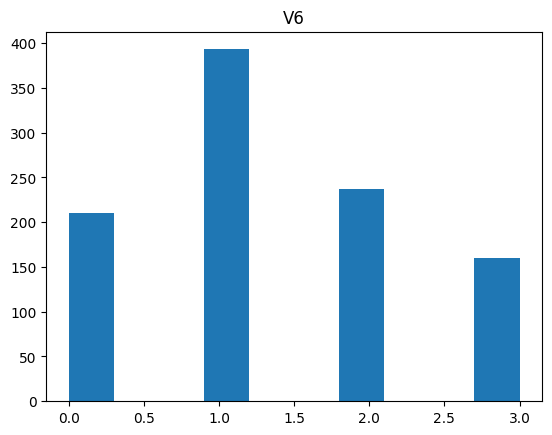

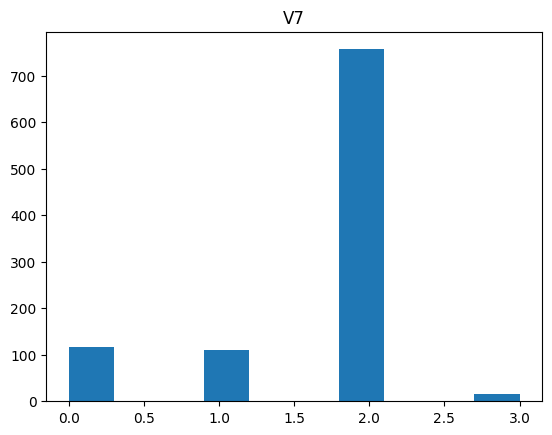

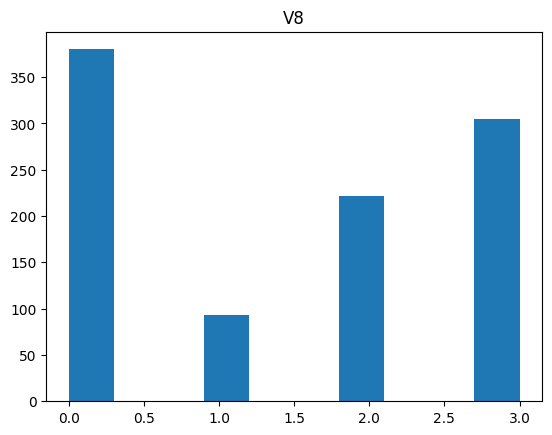

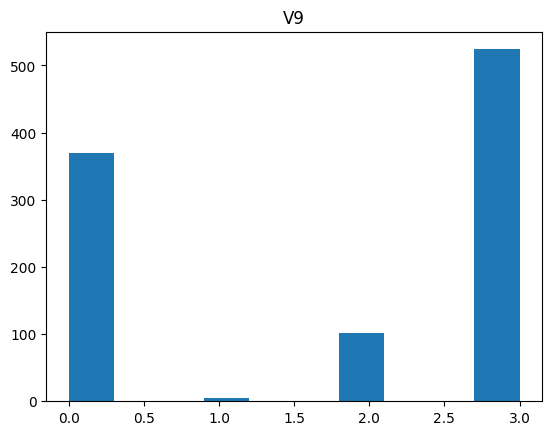

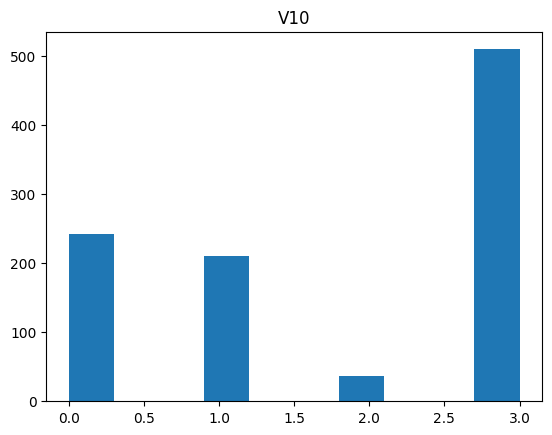

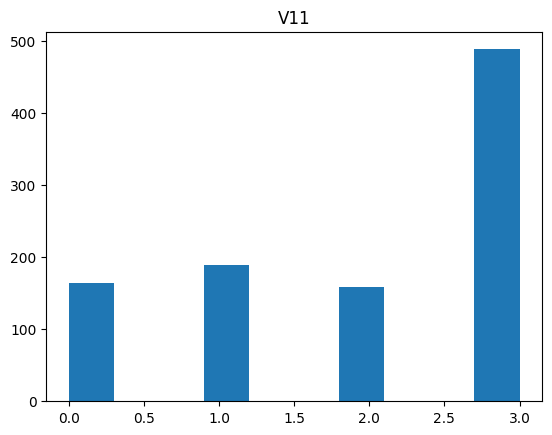

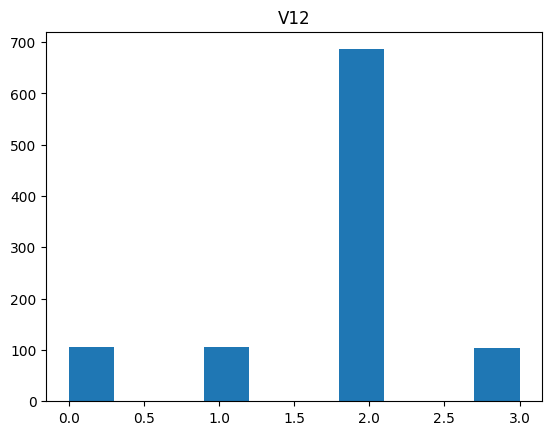

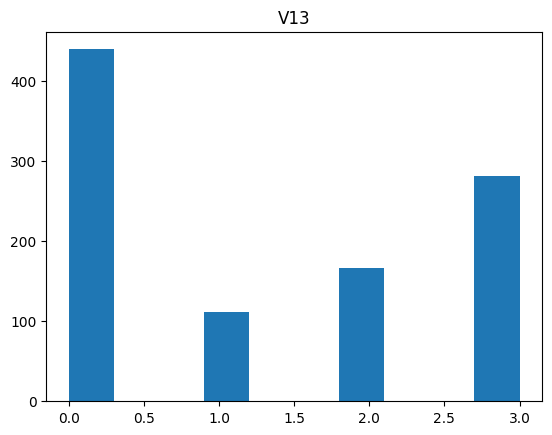

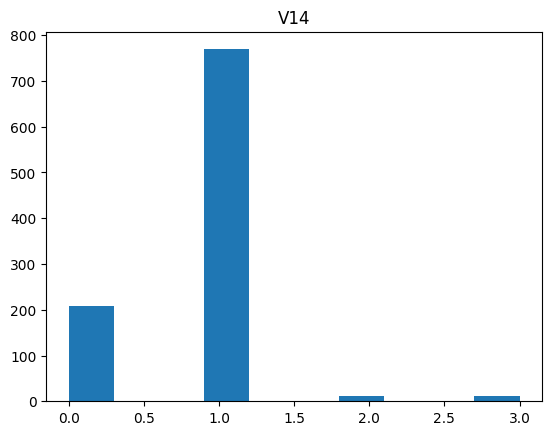

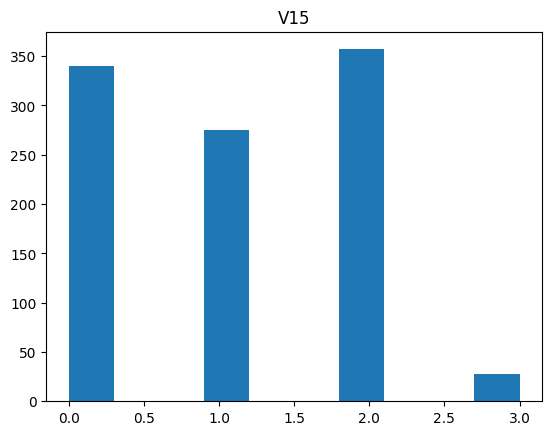

In [ ]:
names = data.columns
items = names[1:]
for i in items:
    d = data[i]
    plt.hist(d)
    plt.title(i)
    plt.show()

## Modelo Bayesiano

In [ ]:
# Variables
data = data[names[1:]]
n_per = data.shape[0]
n_items = data.shape[1]
n_cate = 4

print(n_per, n_items, n_cate)

1000 15 4


In [ ]:
prueba = data.to_numpy()
prueba = prueba + 1
type(prueba)
print(prueba)

[[1 3 4 ... 3 2 1]
 [4 3 3 ... 1 2 1]
 [4 2 3 ... 1 2 1]
 ...
 [1 2 2 ... 2 2 1]
 [1 2 1 ... 1 1 2]
 [2 1 2 ... 1 2 3]]


### Modelos

#### Modelo 1 (Más simple al del artículo).

In [ ]:
model = """
data{
    int<lower=1, upper=5> J; // número de categorías m-1
    int<lower = 0> n_per; // número de personas
    int<lower = 0> n_items; //número de ítems
    int<lower = 1, upper = J> data[n_per, n_items];
}
parameters{
    vector[n_per] theta;
    real<lower=0> alpha [n_items];
    ordered[J-1] beta[n_items]; //category difficulty
}
model{
alpha ~ gamma(0,5);
theta ~ normal(0,1);
for (i in 1: n_items){
for (j in 1:(J-1)){
beta[i,j] ~ normal(0,5);
}}
for (i in 1:n_per){
for (j in 1:n_items){
data[i,j] ~ ordered_logistic(theta[i]*alpha[j],beta[j]);
}}
}
"""

#### Modelo 2 (artículo).

In [ ]:
model_1 = """
data{
int<lower=1, upper=5>  K; //number of categories
int <lower=0>  n_student;
int <lower=0>  n_item;
int<lower=1, upper=K>  Y[n_student,n_item];
}
parameters {
vector[n_student] theta;
real<lower=0> alpha [n_item];
ordered[K-1] kappa[n_item]; //category difficulty
real mu_kappa; //mean of the prior distribution of category difficulty
real<lower=0> sigma_kappa; //sd of the prior distribution of category difficulty
}
model{
alpha ~ cauchy(0,5); 
theta ~ normal(0,1);
for (i in 1: n_item){
for (k in 1:(K-1)){
kappa[i,k] ~ normal(mu_kappa,sigma_kappa);
}}
mu_kappa ~ normal(0,5);
sigma_kappa ~ cauchy(0,5);
for (i in 1:n_student){
for (j in 1:n_item){
Y[i,j] ~ ordered_logistic(theta[i]*alpha[j],kappa[j]);
}}
}
"""

### Build Model

In [ ]:
# data as dic
datos = {"n_student": n_per,
         "n_item": n_items,
         "K": n_cate,
         "Y": prueba}

In [ ]:
posterior = stan.build(model_1, data= datos)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_egehf_wb/model_f6p5nwfk.stan', line 6, column 0: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_egehf_wb/model_f6p5nwfk.stan', line 10, column 0: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_egehf_wb/model_f6p5nwfk.stan', line 11, column 0: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-form

### Ajuste del Modelo

In [ ]:
fit = posterior.sample(num_chains=4, num_samples=1000)

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   1% (101/8000)
Sampling:   2% (200/8000)
Sampling:   4% (300/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1901/8000)
Sampling:  25% (2001/8000)
Sampling:  25% (2002/8000)
Sampling:  26% (2101/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Sampling:  42% (3400/8000)
S

## Visualización del Ajuste del Modelo

In [ ]:
values = fit.to_frame()
names_para = values.columns

In [ ]:
summary = values[names_para[7:]].describe().T
parameters = values[names_para[7:]]

In [138]:
drive.mount("/content/drive")
os.chdir("/content/drive/MyDrive")
%pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive'

In [142]:
summary.to_csv("parameter_estimates.csv")
parameters.to_csv("parameters_raw.csv")

In [ ]:
means_theta = np.mean(values[names_para[7:1007]])
means_alpha = np.mean(values[names_para[1007:1022]])

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


(array([ 25.,  35., 115., 205., 247., 211., 113.,  37.,  10.,   2.]),
 array([-2.49135505, -1.93469587, -1.3780367 , -0.82137752, -0.26471835,
         0.29194083,  0.84860001,  1.40525918,  1.96191836,  2.51857753,
         3.07523671]),
 <BarContainer object of 10 artists>)

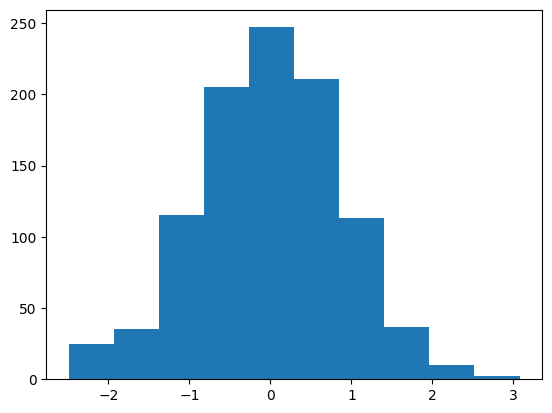

In [ ]:
plt.hist(means_theta)

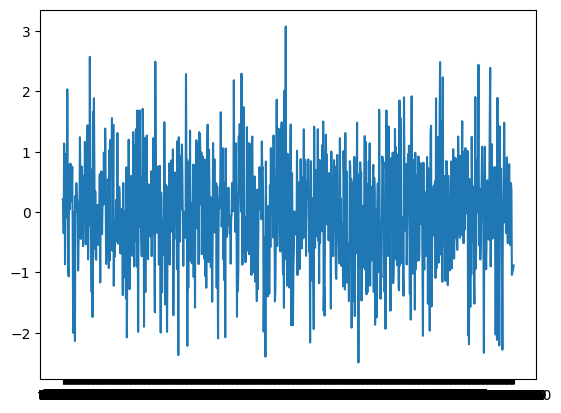

In [ ]:
plt.plot(means_theta)

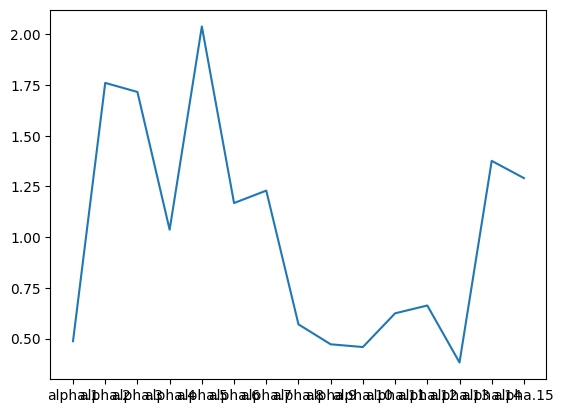

In [ ]:
plt.plot(means_alpha)

In [ ]:
ini = 1022
means_betas = np.empty(shape = (15, 3))

for i in range(15):
    for j in range(3):
        means_betas[i, j] = np.mean(values[names_para[ini]])
        ini += 1

In [ ]:
print(means_betas)

[[-0.78478953 -3.18580518 -2.97940176]
 [-1.07638361 -4.74542616 -1.64197379]
 [-2.52136572 -0.52600428 -0.56231682]
 [-1.18933517 -1.7535325  -2.31725984]
 [-0.25774429 -1.77847804 -0.8758164 ]
 [-0.55347389  0.69883823 -0.71682561]
 [ 0.51260998 -3.32298305  0.5318484 ]
 [-1.552387   -0.11175379 -0.53552078]
 [-0.19347214 -0.65794473 -1.44738399]
 [ 0.20352872  4.54459261  0.61509387]
 [ 0.14985297  5.97461382  1.1418555 ]
 [ 1.89212231  5.73340071  2.04794108]
 [ 4.80238269  0.88921371 -0.09669182]
 [-0.03792845  0.05478552  2.31914888]
 [ 0.96131428  5.28041985  4.27008061]]


In [ ]:
mean_mu_beta = np.mean(values[names_para[1067]])
mean_sigma_beta = np.mean(values[names_para[1068]])

print(mean_mu_beta, mean_sigma_beta)

0.15647965594334654 2.48847221968822
